## Scan Context based odometry estimation

## 데이터 불러오기, 전처리

In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import pykitti
import sys

%matplotlib inline
np.random.seed(777)

sys.path.append('./src')

from kalman_filters import ExtendedKalmanFilter as EKF
from utils import lla_to_enu, normalize_angles

In [2]:
# Odometry Results
f = open("kitti_raw_20110930_0033.txt", 'r')
lines = f.readlines()
lines_f = [[float(i) for i in arr[:-1].split(" ")] for arr in lines]
lines_f = np.array(lines_f)

# kitti dataset
kitti_root_dir = '/datasets/kitti/raw'
kitti_date = '2011_09_30'
kitti_drive = '0033'
dataset = pykitti.raw(kitti_root_dir, kitti_date, kitti_drive)

In [3]:
gt_trajectory_lla = []  # [longitude(deg), latitude(deg), altitude(meter)] x N
gt_yaws = []  # [yaw_angle(rad),] x N
gt_yaw_rates= []  # [vehicle_yaw_rate(rad/s),] x N
gt_forward_velocities = []  # [vehicle_forward_velocity(m/s),] x N

for oxts_data in dataset.oxts:
    packet = oxts_data.packet
    gt_trajectory_lla.append([
        packet.lon,
        packet.lat,
        packet.alt
    ])
    gt_yaws.append(packet.yaw)
    gt_yaw_rates.append(packet.wz)
    gt_forward_velocities.append(packet.vf)

gt_trajectory_lla = np.array(gt_trajectory_lla).T
gt_yaws = np.array(gt_yaws)
gt_yaw_rates = np.array(gt_yaw_rates)
gt_forward_velocities = np.array(gt_forward_velocities)

timestamps = np.array(dataset.timestamps)
elapsed = np.array(timestamps) - timestamps[0]
ts = [t.total_seconds() for t in elapsed]

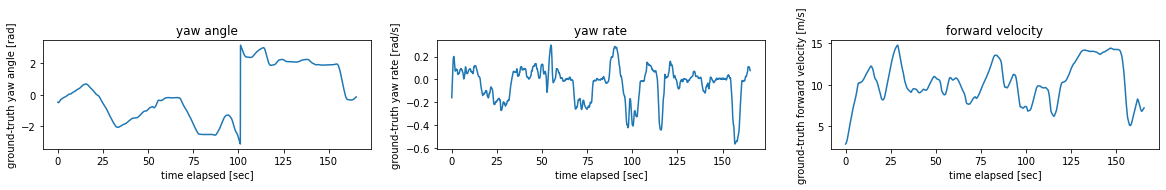

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(20, 2))

ax[0].set_title("yaw angle")
ax[0].plot(ts, gt_yaws)
ax[0].set_xlabel('time elapsed [sec]')
ax[0].set_ylabel('ground-truth yaw angle [rad]')

ax[1].set_title("yaw rate")
ax[1].plot(ts, gt_yaw_rates)
ax[1].set_xlabel('time elapsed [sec]')
ax[1].set_ylabel('ground-truth yaw rate [rad/s]')

ax[2].set_title("forward velocity")
ax[2].plot(ts, gt_forward_velocities)
ax[2].set_xlabel('time elapsed [sec]')
ax[2].set_ylabel('ground-truth forward velocity [m/s]');

## Scan Context

### kitti LiDAR data

In [5]:
import os
import numpy as np
import pykitti
import time

np.random.seed(777)

kitti_root_dir = '/datasets/kitti/raw'
kitti_date = '2011_09_30'
kitti_drive = '0033'

dataset = pykitti.raw(kitti_root_dir, kitti_date, kitti_drive)

for idx, cloud in enumerate(dataset.velo):
#     makePointCloud2Msg(cloud[:, :3], idx, "KITTI", 'xyz')
    print(np.array(cloud[:,:3]).shape)
    print(idx)
    time.sleep(1)
    if idx == 2:
        break

(126997, 3)
0
(126939, 3)
1
(126807, 3)
2


In [6]:
type(dataset.velo)

generator

### generate SCs

In [6]:
import numpy as np
np.set_printoptions(precision=4)
import time
from scipy import spatial

In [7]:
shape=[20,60]
num_candidates=10
threshold=0.15
max_length = 80 # recommended but other (e.g., 100m) is also ok.

ENOUGH_LARGE = 15000 # capable of up to ENOUGH_LARGE number of nodes 
ptclouds = [None] * ENOUGH_LARGE
scancontexts = [None] * ENOUGH_LARGE
ringkeys = [None] * ENOUGH_LARGE
curr_node_idx = 0


def ptcloud2sc(ptcloud, sc_shape, max_length):
    num_ring, num_sector = sc_shape

    gap_ring = max_length/num_ring
    gap_sector = 360/num_sector
    
    enough_large = 500
    sc_storage = np.zeros([enough_large, num_ring, num_sector])
    sc_counter = np.zeros([num_ring, num_sector])
    
    num_points = ptcloud.shape[0]
    
    def xy2theta(x, y):
        if (x >= 0 and y >= 0): 
            theta = 180/np.pi * np.arctan(y/x);
        if (x < 0 and y >= 0): 
            theta = 180 - ((180/np.pi) * np.arctan(y/(-x)));
        if (x < 0 and y < 0): 
            theta = 180 + ((180/np.pi) * np.arctan(y/x));
        if ( x >= 0 and y < 0):
            theta = 360 - ((180/np.pi) * np.arctan((-y)/x));
        return theta
    
    def pt2rs(point, gap_ring, gap_sector, num_ring, num_sector):
        x = point[0]
        y = point[1]
        # z = point[2]

        if(x == 0.0):
            x = 0.001
        if(y == 0.0):
            y = 0.001

        theta = xy2theta(x, y)
        faraway = np.sqrt(x*x + y*y)

        idx_ring = np.divmod(faraway, gap_ring)[0]       
        idx_sector = np.divmod(theta, gap_sector)[0]

        if(idx_ring >= num_ring):
            idx_ring = num_ring-1 # python starts with 0 and ends with N-1

        return int(idx_ring), int(idx_sector)
    
    
    for pt_idx in range(num_points):
        point = ptcloud[pt_idx, :]
        point_height = point[2] + 2.0 # for setting ground is roughly zero 
        
        idx_ring, idx_sector = pt2rs(point, gap_ring, gap_sector, num_ring, num_sector)
        
        if sc_counter[idx_ring, idx_sector] >= enough_large:
            continue
        sc_storage[int(sc_counter[idx_ring, idx_sector]), idx_ring, idx_sector] = point_height
        sc_counter[idx_ring, idx_sector] = sc_counter[idx_ring, idx_sector] + 1

    sc = np.amax(sc_storage, axis=0)
        
    return sc

In [8]:
def show_sc(cloud, ring_res, sector_res, max_length):
    N = len(sector_res)
    fig, ax = plt.subplots(1, N, figsize=(18, 4))
    for i in range(N):
        sc = ptcloud2sc(cloud, [ring_res[i], sector_res[i]], max_length)
        ax[i].imshow(sc)
    plt.show()

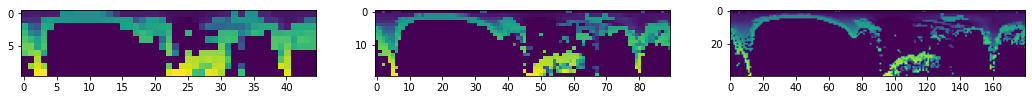

In [10]:
ring_res_multi = np.array([10, 20, 40])
sector_res_multi = np.array([45, 90, 180])

for idx, cloud in enumerate(dataset.velo):
    sample_cloud = np.array(cloud[:,:3])
    show_sc(sample_cloud, ring_res_multi, sector_res_multi, max_length)
    if idx == 0:
        break

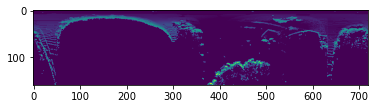

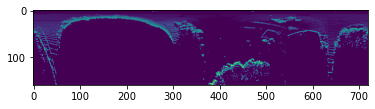

In [117]:
velos = dataset.velo

pt1 = next(velos)
pt2 = next(velos)

sc1 = ptcloud2sc(pt1, [160, 720], max_length)
sc2 = ptcloud2sc(pt2, [160, 720], max_length)

plt.imshow(sc1)
plt.show()
plt.imshow(sc2)
plt.show()

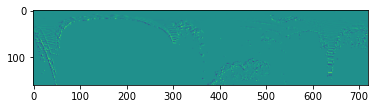

In [118]:
diff = sc2 - sc1
plt.imshow(diff)
plt.show()

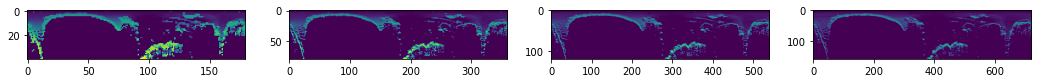

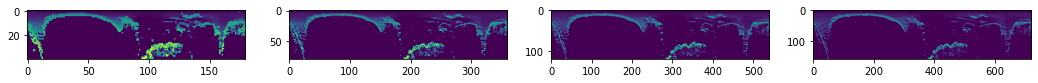

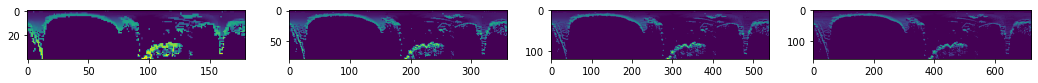

In [119]:
ring_res_multi = np.array([40, 80, 120, 160])
sector_res_multi = np.array([180, 360, 540, 720])

for idx, cloud in enumerate(dataset.velo):
    sample_cloud = np.array(cloud[:,:3])
    show_sc(sample_cloud, ring_res_multi, sector_res_multi, max_length)
    if idx == 2:
        break

### save SC

In [121]:
from tqdm import tqdm
shape=[120,540] # [ring, sector]
max_length = 80

scs = []

for idx, cloud in tqdm(enumerate(dataset.velo)):
    sc = ptcloud2sc(np.array(cloud[:,:3]), shape, max_length)
    scs.append(sc)
#     plt.imshow(sc)
#     plt.show()

1594it [1:25:19,  3.21s/it]


In [122]:
scs_ = np.array(scs)
print(scs_.shape)

(1594, 120, 540)


In [123]:
# np.save('./experiments_sc/scs_120_540', scs_)

### load

In [9]:
scs = np.load('./experiments_sc/scs_120_540.npy')

In [12]:
scs.shape

(1594, 120, 540)

## Experiments

### train

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import numpy as np
np.random.seed(7)

print('Python version : ', sys.version)
print('TensorFlow version : ', tf.__version__)
print('Keras version : ', keras.__version__)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Python version :  3.7.7 (default, Mar 26 2020, 15:48:22) 
[GCC 7.3.0]
TensorFlow version :  1.15.0
Keras version :  2.3.1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11447103132725605274
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 18150368458204453566
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5223022592
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12019516601490852745
physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13648596291528238718
physical_device_desc: "device: XLA_GPU device"
]


Using TensorFlow backend.


In [14]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D, Conv1D
from keras.layers.convolutional import MaxPooling1D, MaxPooling2D

# num_seq = 10
# X_ = []
# for idx in range(num_seq, len(scs)):
#     seq = scs[idx].copy()
#     for i in range(1, num_seq):
#         seq = np.append(seq, scs[idx-i].copy())
#     X_.append(seq)
# X = np.array(X_)

times = np.array(ts)
labels = np.column_stack([gt_yaws.T, gt_forward_velocities.T])
print(labels.shape)

# dataShape = X[0].shape
# labelShape = labels[0].shape

num_seq = 10
X_ = scs.copy()[:,:,:,np.newaxis]
X = X_[num_seq:].copy()
for i in range(1, num_seq):
    X = np.concatenate((X, X_[num_seq-i:-i]), axis=3)
print(X.shape)

times = times[num_seq:]
labels = labels[num_seq:]

dataShape = X[0].shape
labelShape = labels[0].shape

labels, dataShape, labelShape

(1594, 2)


KeyboardInterrupt: 

In [92]:
from sklearn.preprocessing import minmax_scale

train_size, test_size = 1000, 500
x_train, y_train = X[:train_size].astype(np.float64), labels[:train_size]
x_test, y_test = X[train_size:].astype(np.float64), labels[train_size:]

x_train /= np.max(X)
x_test /= np.max(X)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1000, 40, 180, 10), (1000, 2), (584, 40, 180, 10), (584, 2))

In [95]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same',
                 activation='relu',
                 input_shape=dataShape))
model.add(Conv2D(64, (2, 2), activation='relu', padding='same'))
model.add(Conv2D(128, (2, 2), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(2))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 40, 180, 32)       8032      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 40, 180, 64)       8256      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 40, 180, 128)      32896     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 20, 90, 128)       0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 230400)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               23040100  
_________________________________________________________________
dense_14 (Dense)             (None, 2)                

In [96]:
from keras import metrics
batch_size = 128
epochs = 100

# model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.compile(loss='mse', optimizer='adam',
              metrics=['accuracy',
                       metrics.mse, metrics.mean_absolute_percentage_error])
hist = model.fit(x_train, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 verbose=1, 
                 validation_data=(x_test, y_test))

Train on 1000 samples, validate on 584 samples
Epoch 1/100
1000/1000 [==============================] - 19s 19ms/step - loss: 28.6986 - accuracy: 0.9180 - mean_squared_error: 28.6986 - mean_absolute_percentage_error: 220.5027 - val_loss: 12.3360 - val_accuracy: 1.0000 - val_mean_squared_error: 12.3360 - val_mean_absolute_percentage_error: 97.3989
Epoch 2/100
1000/1000 [==============================] - 18s 18ms/step - loss: 4.5331 - accuracy: 1.0000 - mean_squared_error: 4.5331 - mean_absolute_percentage_error: 117.7738 - val_loss: 13.8650 - val_accuracy: 1.0000 - val_mean_squared_error: 13.8650 - val_mean_absolute_percentage_error: 101.8215
Epoch 3/100
1000/1000 [==============================] - 18s 18ms/step - loss: 2.1880 - accuracy: 1.0000 - mean_squared_error: 2.1880 - mean_absolute_percentage_error: 111.1251 - val_loss: 11.2516 - val_accuracy: 1.0000 - val_mean_squared_error: 11.2516 - val_mean_absolute_percentage_error: 105.0174
Epoch 4/100
1000/1000 [==========================

1000/1000 [==============================] - 18s 18ms/step - loss: 0.0011 - accuracy: 1.0000 - mean_squared_error: 0.0011 - mean_absolute_percentage_error: 5.0439 - val_loss: 10.6497 - val_accuracy: 1.0000 - val_mean_squared_error: 10.6497 - val_mean_absolute_percentage_error: 107.9663
Epoch 56/100
1000/1000 [==============================] - 18s 18ms/step - loss: 0.0011 - accuracy: 1.0000 - mean_squared_error: 0.0011 - mean_absolute_percentage_error: 7.8185 - val_loss: 10.7003 - val_accuracy: 1.0000 - val_mean_squared_error: 10.7003 - val_mean_absolute_percentage_error: 109.3898
Epoch 57/100
1000/1000 [==============================] - 18s 18ms/step - loss: 0.0023 - accuracy: 1.0000 - mean_squared_error: 0.0023 - mean_absolute_percentage_error: 15.1335 - val_loss: 10.7160 - val_accuracy: 1.0000 - val_mean_squared_error: 10.7160 - val_mean_absolute_percentage_error: 110.8809
Epoch 58/100
1000/1000 [==============================] - 18s 18ms/step - loss: 0.0013 - accuracy: 1.0000 - mean

Epoch 82/100
1000/1000 [==============================] - 18s 18ms/step - loss: 0.0056 - accuracy: 1.0000 - mean_squared_error: 0.0056 - mean_absolute_percentage_error: 16.9027 - val_loss: 10.6548 - val_accuracy: 1.0000 - val_mean_squared_error: 10.6548 - val_mean_absolute_percentage_error: 108.6846
Epoch 83/100
1000/1000 [==============================] - 18s 18ms/step - loss: 0.0083 - accuracy: 1.0000 - mean_squared_error: 0.0083 - mean_absolute_percentage_error: 23.5878 - val_loss: 10.3229 - val_accuracy: 1.0000 - val_mean_squared_error: 10.3229 - val_mean_absolute_percentage_error: 99.0206
Epoch 84/100
1000/1000 [==============================] - 18s 18ms/step - loss: 0.0075 - accuracy: 1.0000 - mean_squared_error: 0.0075 - mean_absolute_percentage_error: 18.0026 - val_loss: 10.7194 - val_accuracy: 1.0000 - val_mean_squared_error: 10.7194 - val_mean_absolute_percentage_error: 108.6753
Epoch 85/100
1000/1000 [==============================] - 18s 18ms/step - loss: 0.0047 - accuracy:

dict_keys(['val_loss', 'val_accuracy', 'val_mean_squared_error', 'val_mean_absolute_percentage_error', 'loss', 'accuracy', 'mean_squared_error', 'mean_absolute_percentage_error'])


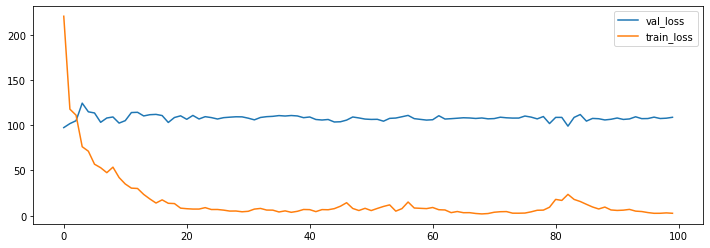

In [97]:
print(hist.history.keys())

val_loss_lst = hist.history['val_mean_absolute_percentage_error']
train_loss_lst = hist.history['mean_absolute_percentage_error']

plt.figure(figsize=(12, 4))
plt.plot(range(0, len(val_loss_lst)), val_loss_lst, label='val_loss')
plt.plot(range(0, len(train_loss_lst)), train_loss_lst, label='train_loss')
plt.legend()
plt.savefig('regression_train_val_score.png')
plt.show()

In [ ]:
gt_trajectory_lla = np.array(gt_trajectory_lla).T
gt_yaws = np.array(gt_yaws)
gt_yaw_rates = np.array(gt_yaw_rates)
gt_forward_velocities = np.array(gt_forward_velocities)

timestamps = np.array(dataset.timestamps)
elapsed = np.array(timestamps) - timestamps[0]
ts = [t.total_seconds() for t in elapsed]

In [98]:
results1 = model.evaluate(x_train, y_train)
results2 = model.evaluate(x_test, y_test)

584/584 [==============================] - 3s 5ms/step


In [99]:
print('Train accuracy: ', results1)
print('Test accuracy: ', results2)

Train accuracy:  [0.00014900955132907256, 1.0, 0.0001490095310145989, 2.9299097061157227]
Test accuracy:  [10.669021631348622, 1.0, 10.669021606445312, 108.79268646240234]


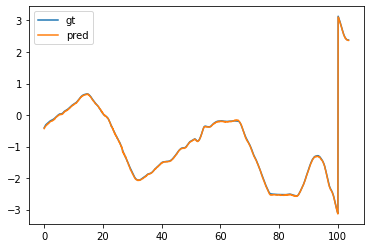

In [100]:
pred = model.predict(x_train)
sz = pred.shape[0]

plt.plot(ts[:sz], y_train[:,0], label='gt')
plt.plot(ts[:sz], pred[:,0], label='pred')
plt.legend()
plt.show()

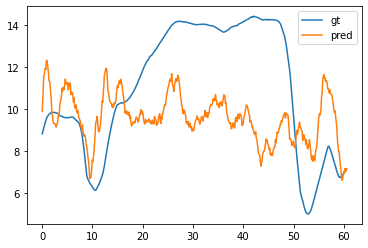

In [101]:
pred = model.predict(x_test)
sz = pred.shape[0]

plt.plot(ts[:sz], y_test[:,1], label='gt')
plt.plot(ts[:sz], pred[:,1], label='pred')
plt.legend()
plt.show()

In [36]:
pred.shape, y_test.shape

((584, 2), (584, 2))

In [33]:
x_test.shape

(584, 40, 180, 10)

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same',
                 activation='relu',
                 input_shape=dataShape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (2, 2), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(2))
model.summary()

In [13]:
import os
import numpy as np 
import pandas as pd 
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [14]:
print(gt_yaws.shape)
print(gt_forward_velocities.shape)

(1594,)
(1594,)


In [15]:
num_seq = 10
X_ = []
for idx in range(num_seq, len(scs)):
    seq = scs[idx].copy()
    for i in range(1, num_seq):
        seq = np.append(seq, scs[idx-i].copy())
    X_.append(seq)
X = np.array(X_)

In [16]:
times = np.array(ts)
labels = np.column_stack([gt_yaws.T, gt_forward_velocities.T])
print(labels.shape)

dataShape = X[0].shape
labelShape = labels[0].shape

(1594, 2)


In [17]:
num_seq = 10
X_ = scs.copy()[:,np.newaxis,:,:]
X = X_[num_seq:].copy()
for i in range(1, num_seq):
    X = np.concatenate((X, X_[num_seq-i:-i]), axis=1)
print(X.shape)

times = times[num_seq:]
labels = labels[num_seq:]

dataShape = X[0].shape
labelShape = labels[0].shape

(1584, 10, 40, 180)


In [18]:
labels, dataShape, labelShape

(array([[-0.4045,  3.5   ],
        [-0.3843,  3.6121],
        [-0.3648,  3.7264],
        ...,
        [-0.1594,  7.0774],
        [-0.1498,  7.125 ],
        [-0.1421,  7.1735]]),
 (10, 40, 180),
 (2,))

#### model

In [19]:
# Model 
from keras import backend as K
K.clear_session()

KernelSize = 5

inputs = keras.layers.Input(shape=(dataShape[0], dataShape[1], dataShape[2]))
x = keras.layers.Conv2D(filters=64, kernel_size=KernelSize, activation='relu', padding='same')(inputs)
x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters=128, kernel_size=KernelSize, activation='relu', padding='same')(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters=256, kernel_size=KernelSize, activation='relu', padding='same')(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(rate=0.7)(x)
x = keras.layers.Dense(units=64)(x)
x = keras.layers.Dropout(rate=0.7)(x)
outputs = keras.layers.Dense(units=labelShape[0], activation='softmax')(x)

model = keras.models.Model(inputs=inputs, outputs=outputs)

In [20]:
# Model Compile 
model.compile(optimizer='adam', loss='mse', metrics=['acc'])
model.build(None,)

#### train

In [21]:
#Train
X_train = X[:500]
y_train = labels[:500]

nEpoch = 200

model.fit(X_train, y_train, epochs=nEpoch, batch_size=64, verbose=1)

Epoch 1/200


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node conv2d_1/convolution (defined at /home/q10/.pyenv/versions/tf2/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3009) ]] [Op:__inference_keras_scratch_graph_2741]

Function call stack:
keras_scratch_graph


In [ ]:
# model save 
modelName = 'experiments_sc/sc_odom_{}_{}.h5'.format(dataShape[1], dataShape[2])
model.save(modelName)

### inference

In [ ]:
import os
import numpy as np 
import pandas as pd 
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

In [ ]:
from keras.models import load_model
modelName = 'experiments_sc/sc_odom_{}_{}.h5'.format(dataShape[1], dataShape[2])
testModel = load_model(modelName)
testModel.summary()

In [ ]:
# Test
X_test = X[500:]
y_test = labels[500:]

In [ ]:
# Predict 
scores_TEST = testModel.evaluate(X_test, y_test, verbose=1, batch_size=1000)
print('- Test score:', scores_TEST[0])
print('- Test accuracy:', scores_TEST[1]*100)
print(' ')

In [ ]:
# save prediction (for later top N analysis )
y_predicted = testModel.predict(X_test)

# save 
filename_y_predicted = 'experiments_sc/predicts' + modelName
np.save(filename_y_predicted, y_seen_predicted)

In [2]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import pykitti
import sys

%matplotlib inline
np.random.seed(777)

sys.path.append('./src')

from kalman_filters import ExtendedKalmanFilter as EKF
from utils import lla_to_enu, normalize_angles


# kitti dataset
kitti_root_dir = '/datasets/kitti/raw'
kitti_date = '2011_09_30'
kitti_drive = '0033'
dataset = pykitti.raw(kitti_root_dir, kitti_date, kitti_drive)


# Data Parsing
gt_trajectory_lla = []  # [longitude(deg), latitude(deg), altitude(meter)] x N
gt_yaws = []  # [yaw_angle(rad),] x N
gt_yaw_rates= []  # [vehicle_yaw_rate(rad/s),] x N
gt_forward_velocities = []  # [vehicle_forward_velocity(m/s),] x N

for oxts_data in dataset.oxts:
    packet = oxts_data.packet
    gt_trajectory_lla.append([
        packet.lon,
        packet.lat,
        packet.alt
    ])
    gt_yaws.append(packet.yaw)
    gt_yaw_rates.append(packet.wz)
    gt_forward_velocities.append(packet.vf)

gt_trajectory_lla = np.array(gt_trajectory_lla).T
gt_yaws = np.array(gt_yaws)
gt_yaw_rates = np.array(gt_yaw_rates)
gt_forward_velocities = np.array(gt_forward_velocities)

timestamps = np.array(dataset.timestamps)
elapsed = np.array(timestamps) - timestamps[0]
ts = [t.total_seconds() for t in elapsed]

name = kitti_date + kitti_drive
np.save('./experiments_sc/gt_trajectory_lla'+name, gt_trajectory_lla)
np.save('./experiments_sc/gt_yaws'+name, gt_yaws)
np.save('./experiments_sc/gt_yaw_rates'+name, gt_yaw_rates)
np.save('./experiments_sc/gt_forward_velocities'+name, gt_forward_velocities)
np.save('./experiments_sc/timestamps'+name, np.array(timestamps))

In [4]:
timestamps

array([datetime.datetime(2011, 9, 30, 13, 12, 10, 525111),
       datetime.datetime(2011, 9, 30, 13, 12, 10, 635103),
       datetime.datetime(2011, 9, 30, 13, 12, 10, 735106), ...,
       datetime.datetime(2011, 9, 30, 13, 14, 55, 621794),
       datetime.datetime(2011, 9, 30, 13, 14, 55, 731732),
       datetime.datetime(2011, 9, 30, 13, 14, 55, 831745)], dtype=object)

In [3]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import pykitti
import sys

%matplotlib inline
np.random.seed(777)

sys.path.append('./src')

from kalman_filters import ExtendedKalmanFilter as EKF
from utils import lla_to_enu, normalize_angles


# kitti dataset
kitti_root_dir = '/datasets/kitti/raw'
kitti_date = '2011_09_30'
kitti_drive = '0033'

name = kitti_date + kitti_drive
gt_trajectory_lla = np.load('./experiments_sc/gt_trajectory_lla'+name+'.npy')
gt_yaws = np.load('./experiments_sc/gt_yaws'+name+'.npy')
gt_yaw_rates = np.load('./experiments_sc/gt_yaw_rates'+name+'.npy')
gt_forward_velocities = np.load('./experiments_sc/gt_forward_velocities'+name+'.npy')
timestamps = np.load('./experiments_sc/timestamps'+name+'.npy')

elapsed = np.array(timestamps) - timestamps[0]
ts = [t.total_seconds() for t in elapsed]

ValueError: Object arrays cannot be loaded when allow_pickle=False

# test

In [1]:
import pykitti
import numpy as np

# kitti dataset
kitti_root_dir = '/datasets/kitti/raw'
kitti_date = '2011_09_30'
kitti_drive = '0028'
dataset = pykitti.raw(kitti_root_dir, kitti_date, kitti_drive)


filename = kitti_date + '_' + kitti_drive
# scs = np.load('./experiments_sc/scs_120_540.npy')
scs = np.load('./experiments_sc/' + filename + '_scs_120_540.npy')

In [2]:
import tensorflow as tf
import os
import keras.backend.tensorflow_backend as KK

def get_session(gpu_fraction=0.6):
    '''Assume that you have 6GB of GPU memory and want to allocate ~2GB'''
    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

KK.set_session(get_session())

Using TensorFlow backend.


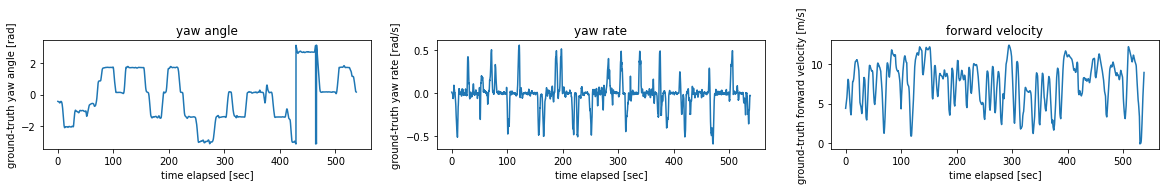

In [3]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import sys

%matplotlib inline
np.random.seed(777)

sys.path.append('./src')

from kalman_filters import ExtendedKalmanFilter as EKF
from utils import lla_to_enu, normalize_angles

# Data Parsing
gt_trajectory_lla = []  # [longitude(deg), latitude(deg), altitude(meter)] x N
gt_yaws = []  # [yaw_angle(rad),] x N
gt_yaw_rates= []  # [vehicle_yaw_rate(rad/s),] x N
gt_forward_velocities = []  # [vehicle_forward_velocity(m/s),] x N

for oxts_data in dataset.oxts:
    packet = oxts_data.packet
    gt_trajectory_lla.append([
        packet.lon,
        packet.lat,
        packet.alt
    ])
    gt_yaws.append(packet.yaw)
    gt_yaw_rates.append(packet.wz)
    gt_forward_velocities.append(packet.vf)

gt_trajectory_lla = np.array(gt_trajectory_lla).T
gt_yaws = np.array(gt_yaws)
gt_yaw_rates = np.array(gt_yaw_rates)
gt_forward_velocities = np.array(gt_forward_velocities)

timestamps = np.array(dataset.timestamps)
elapsed = np.array(timestamps) - timestamps[0]
ts = [t.total_seconds() for t in elapsed]


# Visualize
fig, ax = plt.subplots(1, 3, figsize=(20, 2))

ax[0].set_title("yaw angle")
ax[0].plot(ts, gt_yaws)
ax[0].set_xlabel('time elapsed [sec]')
ax[0].set_ylabel('ground-truth yaw angle [rad]')

ax[1].set_title("yaw rate")
ax[1].plot(ts, gt_yaw_rates)
ax[1].set_xlabel('time elapsed [sec]')
ax[1].set_ylabel('ground-truth yaw rate [rad/s]')

ax[2].set_title("forward velocity")
ax[2].plot(ts, gt_forward_velocities)
ax[2].set_xlabel('time elapsed [sec]')
ax[2].set_ylabel('ground-truth forward velocity [m/s]');

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import numpy as np
from numpy import array
np.random.seed(7)

from sklearn.preprocessing import minmax_scale
from keras import metrics

print('Python version : ', sys.version)
print('TensorFlow version : ', tf.__version__)
print('Keras version : ', keras.__version__)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


Python version :  3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 23:51:54) 
[GCC 7.3.0]
TensorFlow version :  1.15.0
Keras version :  2.3.1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17827223063319619271
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8725762919617035672
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5020070707
locality {
  bus_id: 1
  links {
  }
}
incarnation: 396587479060052914
physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14764681568595287261
physical_device_desc: "device: XLA_GPU device"
]


In [5]:
# data, label
times = np.array(ts)
labels = np.column_stack([gt_yaws.T, gt_forward_velocities.T])
d_times = times - np.append(0, times[:-1])
labels[:,0] = labels[:,0] * d_times

# SC preprocessing
X = scs.copy()
# X = X[1:] - X[:-1]
num_data, h, w = X.shape

times = times[:num_data]
labels = labels[:num_data]

input_shape = X[0].shape
label_shape = labels[0].shape

print("SC shape:", X.shape)
print("label shape:", labels.shape)

trainval_ratio = 0.7
train_size = int(num_data * trainval_ratio)
x_train, y_train = X[:train_size].astype(np.float64), labels[:train_size]
x_test, y_test = X[train_size:].astype(np.float64), labels[train_size:]

x_train /= np.max(X)
x_test /= np.max(X)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

SC shape: (5177, 120, 540)
label shape: (5177, 2)


((3623, 120, 540), (3623, 2), (1554, 120, 540), (1554, 2))

In [84]:
b = []
a = np.array([[1,2,3], [1,2,3], [1,2,3]])[:,:,np.newaxis]

np.append(a,a, axis=2)

b.append(a)
b.append(a)
np.array(b).shape, a.shape

((2, 3, 3, 1), (3, 3, 1))

In [6]:
import numpy as np
import math
from tensorflow.keras.utils import Sequence

class Dataloader(Sequence):
    def __init__(self, X, Y, batch_size, shuffle=False):
        self.x, self.y = X, Y
        self.batch_size = batch_size
        self.shuffle=shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)
    
    def concat_sc(self, num_seq, index):
        idx = index + 1
        if idx - num_seq <= 0:
            idx = num_seq
            
        present_idx = range(idx-num_seq, idx)
        past_idx = range(idx-num_seq-1, idx-1)
        
        seq_sc = []
        for i in range(num_seq):
            seq_sc.append(self.x[present_idx[i]] - self.x[past_idx[i]])
            
        return np.transpose(np.array(seq_sc), (1,2,0))

    def __getitem__(self, idx):
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = [self.concat_sc(10, i) for i in indices]
        batch_y = [self.y[i] for i in indices]

        return np.array(batch_x), np.array(batch_y)

    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)
            

train_loader = Dataloader(x_train, y_train, 32, shuffle=True)
valid_loader = Dataloader(x_test, y_test, 32)

In [7]:
with tf.device('/gpu:0'):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(120,540,10)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2))
    
    model.summary()
    model.compile(loss='mse', optimizer='adam',
                  metrics=['accuracy',
                           metrics.mse, metrics.mean_absolute_percentage_error])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 118, 538, 32)      2912      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 59, 269, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 267, 64)       18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 133, 64)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 131, 128)      73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 65, 128)       0         
______________________________________

In [ ]:
from keras import metrics
epochs = 100

hist = model.fit(
    train_loader, epochs=epochs, verbose=1, validation_data=valid_loader)


Epoch 1/100


dict_keys(['val_loss', 'val_accuracy', 'val_mean_squared_error', 'val_mean_absolute_percentage_error', 'loss', 'accuracy', 'mean_squared_error', 'mean_absolute_percentage_error'])


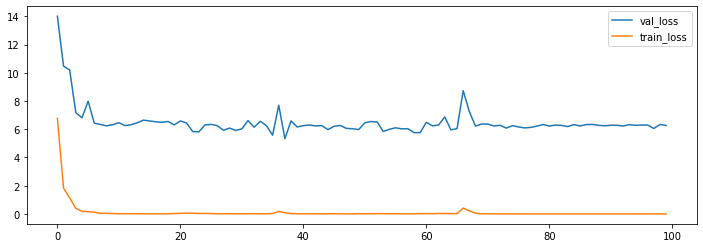

In [11]:
print(hist.history.keys())

val_loss_lst = hist.history['val_mean_squared_error']
train_loss_lst = hist.history['mean_squared_error']

plt.figure(figsize=(12, 4))
plt.plot(range(0, len(val_loss_lst)), val_loss_lst, label='val_loss')
plt.plot(range(0, len(train_loss_lst)), train_loss_lst, label='train_loss')
plt.legend()
plt.savefig('regression_train_val_score.png')
plt.show()

In [12]:
results1 = model.evaluate(x_train, y_train)
results2 = model.evaluate(x_test, y_test)

print('Train accuracy: ', results1)
print('Test accuracy: ', results2)

ValueError: Error when checking input: expected conv2d_1_input to have 4 dimensions, but got array with shape (1115, 120, 540)

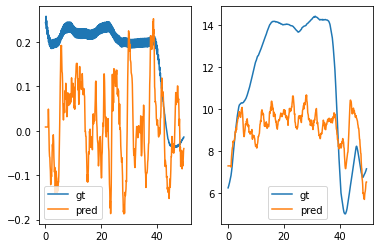

In [16]:
pred = model.predict(valid_loader)
sz = pred.shape[0]

plt.subplot(1,2,1)
plt.plot(ts[:sz], y_test[:,0], label='gt')
plt.plot(ts[:sz], pred[:,0], label='pred')
plt.legend()
plt.subplot(1,2,2)
plt.plot(ts[:sz], y_test[:,1], label='gt')
plt.plot(ts[:sz], pred[:,1], label='pred')
plt.legend()
plt.show()

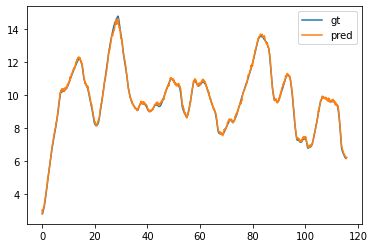

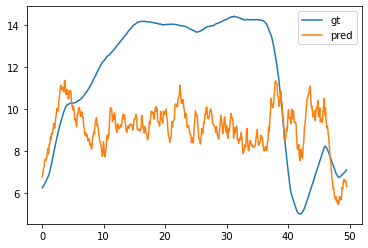

In [46]:
pred = model.predict(x_train)
sz = pred.shape[0]

plt.plot(ts[:sz], y_train[:,1], label='gt')
plt.plot(ts[:sz], pred[:,1], label='pred')
plt.legend()
plt.show()

128
pred = model.predict(x_test)
sz = pred.shape[0]

plt.plot(ts[:sz], y_test[:,1], label='gt')
plt.plot(ts[:sz], pred[:,1], label='pred')
plt.legend()
plt.show()